In [4]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [31]:
pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv').std()

Time      47488.145955
V1            1.958696
V2            1.651309
V3            1.516255
V4            1.415869
V5            1.380247
V6            1.332271
V7            1.237094
V8            1.194353
V9            1.098632
V10           1.088850
V11           1.020713
V12           0.999201
V13           0.995274
V14           0.958596
V15           0.915316
V16           0.876253
V17           0.849337
V18           0.838176
V19           0.814041
V20           0.770925
V21           0.734524
V22           0.725702
V23           0.624460
V24           0.605647
V25           0.521278
V26           0.482227
V27           0.403632
V28           0.330083
Amount      250.120109
Class         0.041527
dtype: float64

In [5]:
mpl.rcParams['figure.figsize'] = (12,10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [16]:
# read data set

file = tf.keras.utils
raw_df = pd.read_csv('https://raw.githubusercontent.com/tjsipin/MacDonald-REU-Summer-22/main/models/data/gap_inp_early_2.csv')
raw_df.head()

,Year,Country,Population,Cutaneous.Leishmaniasis,Dengue,Malaria,Mucosal.Leishmaniasis,Visceral.Leishmaniasis,Yellow.Fever,LST_Day,...,Dengue_Aeg_OptTemp,Chik_Alb_OptTemp,Chik_Aeg_OptTemp,Zika_OptTemp,Malaria_OptTemp,NDVI,EVI,Precip,StableLights,SWOccurrence
0,2007,Colombia,1801730,0.000555,0.002775,0.002220,0.00000,0.0,0.0,24.086593,...,0,14,0,0,22,0.500981,0.304495,2087.610085,37.972903,17.033807
1,2008,Colombia,1839334,0.005980,0.493657,0.010874,0.00000,0.0,0.0,23.432834,...,0,8,0,0,9,0.475580,0.287916,2553.313095,20.001042,17.033807
2,2009,Colombia,1894391,0.001584,0.218012,0.009502,0.00000,0.0,0.0,23.803182,...,1,9,1,1,16,0.527427,0.329218,1812.452090,38.951077,17.033807
3,2010,Colombia,1937458,0.003097,8.036303,0.018065,0.00000,0.0,0.0,24.686513,...,2,19,2,2,22,0.499809,0.312449,2402.545373,45.657085,17.033807
4,2011,Colombia,1960132,0.003061,0.409156,0.005102,0.00051,0.0,0.0,23.795693,...,0,13,0,0,18,0.492869,0.322488,2430.899353,40.699944,17.033807


In [20]:
# thresh
raw_df['Cutaneous.Leishmaniasis'].describe()

# high vs. low thresh
hlt = raw_df['Cutaneous.Leishmaniasis'].describe()[6]

# Turned Cutaneous.Leishmaniasis to binary target (high vs. low)
raw_df.loc[raw_df['Cutaneous.Leishmaniasis'] < hlt, 'Cutaneous.Leishmaniasis'] = 0
raw_df.loc[raw_df['Cutaneous.Leishmaniasis'] > hlt, 'Cutaneous.Leishmaniasis'] = 1

In [21]:
# examine class label imbalance
neg, pos = np.bincount(raw_df['Cutaneous.Leishmaniasis'])
total = neg + pos
print('Examples:\n      Total: {}\n     Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total
))

Examples:
      Total: 31887
     Positive: 7972 (25.00% of total)



In [26]:
# summary of raw_df

raw_df.std()

/var/folders/nj/v28m9jyd30jc52dz2z8b2hrr0000gn/T/ipykernel_38522/540949080.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  raw_df.std()


Year                            3.793120
Population                 257081.430292
Cutaneous.Leishmaniasis         0.433024
Dengue                          8.199956
Malaria                        36.558068
Mucosal.Leishmaniasis           0.092123
Visceral.Leishmaniasis          0.110532
Yellow.Fever                    0.020812
LST_Day                         3.253400
LST_Night                       3.865745
OptTemp_Obs                    10.466077
Dengue_Alb_OptTemp              8.040556
Dengue_Aeg_OptTemp              5.155187
Chik_Alb_OptTemp                8.040556
Chik_Aeg_OptTemp                5.155187
Zika_OptTemp                    5.155187
Malaria_OptTemp                 7.308774
NDVI                            0.086126
EVI                             0.066292
Precip                        760.737413
StableLights                    8.674027
SWOccurrence                   23.073426
dtype: float64

In [54]:
cleaned_df = raw_df.copy()

# Remove unwanted columns
cleaned_df.drop(['Dengue','Malaria', 'Year', 'Mucosal.Leishmaniasis', 'Visceral.Leishmaniasis', 'Yellow.Fever'], axis = 1) # remove OptTemps?

# Turn columns with high variance to log-space
eps = 0.001
cleaned_df['Log_Population'] = np.log(cleaned_df.pop('Population') + eps)
# cleaned_df['Log_OptTemp_Obs'] = np.log(cleaned_df.pop('OptTemp_Obs') + eps)
# cleaned_df['Log_Dengue_Alb_OptTemp'] = np.log(cleaned_df.pop('Dengue_Alb_OptTemp') + eps)
# cleaned_df['Log_Chik_Alb_OptTemp'] = np.log(cleaned_df.pop('Chik_Alb_OptTemp') + eps)
# cleaned_df['Log_Chik_Aeg_OptTemp'] = np.log(cleaned_df.pop('Chik_Aeg_OptTemp') + eps)
# cleaned_df['Log_Zika_OptTemp'] = np.log(cleaned_df.pop('Zika_OptTemp') + eps)
# cleaned_df['Log_Malaria_OptTemp'] = np.log(cleaned_df.pop('Malaria_OptTemp') + eps)
# Do this for every std greater than 1?

cleaned_df['Log_Precip'] = np.log(cleaned_df.pop('Precip') + eps)

cleaned_df = pd.get_dummies(cleaned_df)



In [55]:
# Use a utility from sklearn to split and shuffle your data set
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features
train_labels = np.array(train_df.pop('Cutaneous.Leishmaniasis'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Cutaneous.Leishmaniasis'))
test_labels = np.array(test_df.pop('Cutaneous.Leishmaniasis'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [56]:
# Normalize input features using sklearn StandardScaler (set mean to 0 and std to 1)
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features) 

# Note: the StandardScaler is only fit using the train_features to be sure the model isn't peeking at the validation or test sets

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Testing labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Testing features shape:', test_features.shape)


Training labels shape: (20407,)
Validation labels shape: (5102,)
Testing labels shape: (6378,)
Training features shape: (20407, 24)
Validation features shape: (5102, 24)
Testing features shape: (6378, 24)


Text(0.5, 0.98, 'Negative distribution')

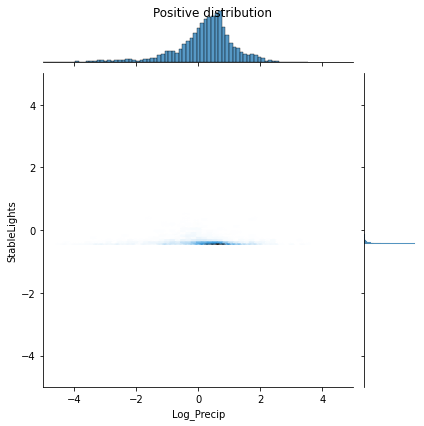

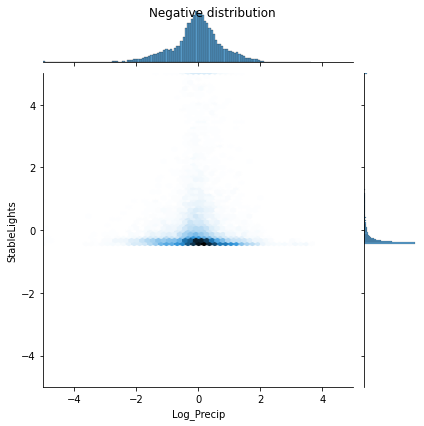

In [57]:
# Look at data distribution
pos_df = pd.DataFrame(
    train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(
    train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['Log_Precip'],
              y=pos_df['StableLights'],
              kind='hex',
              xlim=(-5,5),
              ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['Log_Precip'],
              y=neg_df['StableLights'],
              kind='hex',
              xlim=(-5,5),
              ylim=(-5,5))
plt.suptitle("Negative distribution")


## Define the model and metrics
Define a function that creates a simple neural network with a densely connected hidden layer, a dropout layer to *reduce overfitting*, and an output sigmoid layer that returns the probability of a municipality being high risk of having high cutaneous leishmaniasis cases.

In [59]:


# Define the model and metrics
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')  # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-08 16:47:51.449880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-08 16:47:51.462665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Baseline model
### Building the model
**Note:** This model won't handle the class imbalance well. This will be imporved later.

We create and train the model using the function defined earlier. Notice that the model is fit usinga  larger than default batch size of 2048. This is important as it ensures that each batch has a decent chance of containing a few positive samples. If the batch size is too small, then there will likely have no 